Data Referece:

UCI Machine Learning Repository. "*Online News Popularity Data Set*". [online] Available at: http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

init_df=pd.read_csv('OnlineNewsPopularity.csv',header=0)

In [2]:
# Strip the space in the column name

new_col={}
for col in init_df.columns.values:
    newcol=col.lstrip()
    new_col[col]=newcol
mod_df=init_df.rename(columns=new_col)

In [3]:
#drop the url and timedelta columns
mod_df=mod_df.drop(['url','timedelta'],axis=1)

In [4]:
# Check missing values
mod_df.isnull().any()

n_tokens_title                   False
n_tokens_content                 False
n_unique_tokens                  False
n_non_stop_words                 False
n_non_stop_unique_tokens         False
num_hrefs                        False
num_self_hrefs                   False
num_imgs                         False
num_videos                       False
average_token_length             False
num_keywords                     False
data_channel_is_lifestyle        False
data_channel_is_entertainment    False
data_channel_is_bus              False
data_channel_is_socmed           False
data_channel_is_tech             False
data_channel_is_world            False
kw_min_min                       False
kw_max_min                       False
kw_avg_min                       False
kw_min_max                       False
kw_max_max                       False
kw_avg_max                       False
kw_min_avg                       False
kw_max_avg                       False
kw_avg_avg               

Text(0.5,1,'Shares Distribution')

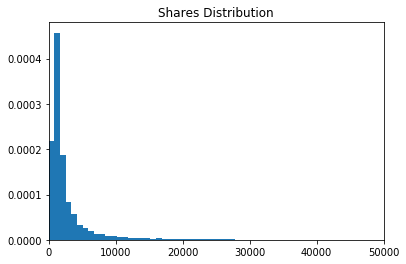

In [18]:
# Plot the target variables

plt.hist(mod_df['shares'],bins=1000,density=True)
plt.xlim(0,50000)
plt.title('Shares Distribution')

In [6]:
# Convert shares to binary target variables

seperate_line=mod_df['shares'].quantile(q=0.75)

convert_df=mod_df.copy()
convert_df['shares']=convert_df['shares'].where(convert_df['shares']<seperate_line,1)
convert_df['shares']=convert_df['shares'].where(convert_df['shares']==1,0)

In [192]:
#split data randomly into 8:2 for training data and test data

convert_df_random=convert_df.reindex(np.random.permutation(convert_df.index))
convert_df_split=int(np.floor(convert_df.shape[0]*0.8))
train_data=convert_df_random[:convert_df_split].reset_index(drop=True)
validation_data=convert_df_random[convert_df_split:].reset_index(drop=True)

In [193]:
# Build the decision tree classifier function
def DT(d,l):
    dt=DecisionTreeClassifier(criterion='gini',max_depth=d,min_samples_leaf=l)
    dt.fit(train_data.drop('shares',axis=1),train_data['shares'])
    
    #auc score
    dt_auc=roc_auc_score(validation_data['shares'],dt.predict_proba(validation_data.drop('shares',axis=1))[:,1])
    
    return dt_auc

In [194]:
# Convert all auc_score to a dataframe

dict_dt={'max_depth':[],'min_samples_leaf':[],'auc_score':[]}

d_list=[100,150,200,300,500,800]
l_list=[10,50,100,300,500,1000]

for d in d_list:
    for l in l_list:
        auc_score=DT(d,l)
            
        dict_dt['max_depth'].append(d)
        dict_dt['min_samples_leaf'].append(l)
        dict_dt['auc_score'].append(auc_score)

df_dt=pd.DataFrame(dict_dt)

In [195]:
# Find the best hyperparameter for the best auc
max_depth1=df_dt[df_dt['auc_score']==df_dt['auc_score'].max()]['max_depth'].iloc[0]
min_samples_leaf1=df_dt[df_dt['auc_score']==df_dt['auc_score'].max()]['min_samples_leaf'].iloc[0]

In [196]:
# Use recursive feature elimination to transform the data
estimator=DecisionTreeClassifier(criterion='gini',max_depth=max_depth1,min_samples_leaf=min_samples_leaf1)
selector=RFE(estimator, 12, step=1)
truncate_array=selector.fit_transform(convert_df.drop('shares',axis=1),convert_df['shares'])

In [197]:
column_of_interest=np.where(selector.get_support()==True)[0].tolist()
truncate_df=convert_df.iloc[:,column_of_interest].merge(convert_df['shares'].to_frame(),left_index=True,right_index=True)

In [198]:
# Split data to test data for 10% of total data and keep the original proportion 

nonpopular_total=truncate_df[truncate_df['shares']==0]
nonpopular_total_random=nonpopular_total.reindex(np.random.permutation(nonpopular_total.index))

nonpopular_split=int(np.floor(nonpopular_total.shape[0]*0.9))

nonpopular_left=nonpopular_total_random[:nonpopular_split]
nonpopular_test=nonpopular_total_random[nonpopular_split:]

popular_total=truncate_df[truncate_df['shares']==1]
popular_total_random=popular_total.reindex(np.random.permutation(popular_total.index))

popular_split=int(np.floor(popular_total.shape[0]*0.9))

popular_left=popular_total_random[:popular_split]
popular_test=popular_total_random[popular_split:]

test_data=pd.concat([nonpopular_test,popular_test],axis=0).reset_index(drop=True)
left_data=pd.concat([nonpopular_left,popular_left],axis=0).reset_index(drop=True)

#split the left_data to training and validation based on 8:2
left_data_random=left_data.reindex(np.random.permutation(left_data.index))
left_data_split=int(np.floor(left_data.shape[0]*0.8))
train_data=left_data_random[:left_data_split].reset_index(drop=True)
validation_data=left_data_random[left_data_split:].reset_index(drop=True)

#downsample trainig_data and train_validation_data
def downsample(data):
    keep_data=data[data['shares']==1]
    down_size=keep_data.shape[0]
    down_data=data[data['shares']==0]
    downed_data=down_data.reindex(np.random.permutation(down_data.index))[:down_size]
    final_data=pd.concat([keep_data,downed_data],axis=0).reset_index(drop=True)
    return final_data

downed_left_data=downsample(left_data)
downed_train_data=downsample(train_data)

    
downed_train_data.to_csv('train_data.csv')
validation_data.to_csv('validation_data.csv')
downed_left_data.to_csv('train_validation_data.csv')
test_data.to_csv('test_data.csv')